<a href="https://colab.research.google.com/github/davidetorre92/PhD_AIMed_LISC/blob/main/PhDAIMed_Leukocytes_Segmentation_with_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import io

os.chdir('/content/drive/MyDrive/PhD/Exams/Image')

import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from IPython.display import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

First let's display how the dataset is organized

In [2]:
for walk_path in os.walk('.'):
  print(walk_path)

('.', ['LISC Database', 'Checkpoints', 'Preprocessed'], [])
('./LISC Database', ['More Dataset without Ground Truth', 'Main Dataset', 'Ground Truth Segmentation'], ['read_me.txt'])
('./LISC Database/More Dataset without Ground Truth', ['alll'], [])
('./LISC Database/More Dataset without Ground Truth/alll', [], ['20020515-61.bmp', '20020515-65.bmp', '20020515-66.bmp', '20020515-67.bmp', '20020515-68.bmp', '20020515-69.bmp', '20020515-70.bmp', '20020515-71.bmp', '20020515-72.bmp', '20020515-73.bmp', '20020515-74.bmp', '20020515-77.bmp', '20020515-78.bmp', '20020515-79.bmp', '20020515-80.bmp', '20020515-81.bmp', '20020515-82.bmp', '20020515-83.bmp', '20020515-84.bmp', '20020515-85.bmp', '20020515-86.bmp', '20020515-87.bmp', '20020515-88.bmp', '20020515-89.bmp', '20020515-90.bmp', '20020515-91.bmp', '20020515-92.bmp', '20020515-93.bmp', '20020515-94.bmp', '20020515-96.bmp', '20020515-97.bmp', '20020515-98.bmp', '20020515-99.bmp', '20020515-100.bmp', '20020515-101.bmp', '20020515-102.bmp', 

## The LISC Database
The LISC (Leukocyte Images for Segmentation and Classification) database includes the hematological images taken from peripheral blood of healthy subjects. The database has been released to enable comparative evaluation of different techniques on nucleus and cytoplasm segmentation and also recognition of different white blood cells in hematological images.

Samples were obtained from 8 healthy individuals by taking peripheral blood samples. A total of 400 samples were collected from 100 microscope slides. These slides were prepared by smearing and staining the samples using the Gismo-Right technique. Images of the stained peripheral blood were captured using a light microscope (Microscope-Axioskope 40) equipped with an achromatic lens at a magnification of 100. The images were then recorded using a digital camera (Sony Model No. SSCDC50AP) and saved in the BMP format. The images have a resolution of 720×576 pixels and are in color.

All of the images were obtained from the Hematology-Oncology and BMT Research Center of Imam Khomeini hospital in Tehran, Iran. A hematologist classified the images into different categories of normal leukocytes, including basophil, eosinophil, lymphocyte, monocyte, and neutrophil. Additionally, an expert manually segmented the areas corresponding to the nucleus and cytoplasm in the images.

### Data collection

The subfolder names correspond to different types of leukocytes. Here's a breakdown of what each name represents:

1. `'mono'`: This subfolder contains photographs of monocytes. Monocytes are a type of white blood cell that plays a crucial role in the immune system's response to infections and inflammation.

2. `'eosi'`: This subfolder is dedicated to eosinophils. Eosinophils are another type of white blood cell involved in the immune response, particularly in combating parasitic infections and controlling allergic reactions.

3. `'mixt'`: This subfolder contain leukocytes that do not belong exclusively to one specific type. It could include mixed leukocytes or cells that exhibit characteristics of multiple types.

4. `'Baso'`: This subfolder contains images of basophils. Basophils are a type of white blood cell involved in allergic reactions and immune responses against parasites.
<img src='https://static.wikia.nocookie.net/once-upon-a-time-life/images/5/5f/Basophils.png/revision/latest/scale-to-width-down/210?cb=20180702154810' width=200>

5. `'neut'`: The 'neut' subfolder corresponds to neutrophils. Neutrophils are the most abundant type of white blood cells and play a crucial role in fighting bacterial infections.
<img src='https://static.wikia.nocookie.net/once-upon-a-time-life/images/2/22/Neutrophil_granulocite.png/revision/latest/scale-to-width-down/210?cb=20180703112027' width=200>

6. `'lymp'`: This subfolder contains lymphocytes. Lymphocytes are a type of white blood cell responsible for immune responses, including antibody production and targeted destruction of infected cells.
<img src='https://static.wikia.nocookie.net/once-upon-a-time-life/images/2/2d/Lymphocytes_b.png/revision/latest?cb=20180702163802' width=200>

Please note that the provided names are commonly used abbreviations for the respective leukocyte types

<img src='https://nci-media.cancer.gov/pdq/media/images/503952-571.jpg'>

## Image exploration

In [3]:
leukocytes_types = ['mono',
                    'eosi',
                    'mixt',
                    'Baso',
                    'neut',
                    'lymp'
                    ]
main_dataset = lambda name: f'./LISC Database/Main Dataset/{name}/'
segmentation_dataset = lambda name: f'./LISC Database/Ground Truth Segmentation/{name}/areaforexpert1/'

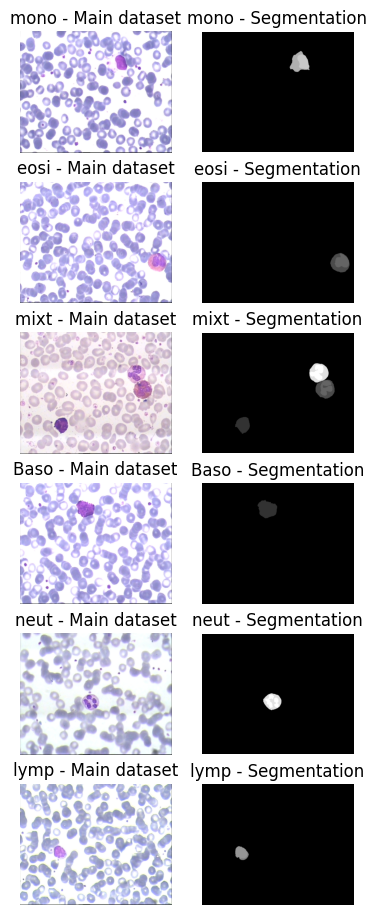

In [4]:
fig, axs = plt.subplots(len(leukocytes_types), 2, figsize = (4.3, 11.4))

for i, name in enumerate(leukocytes_types):
  main_dataset_image_path = main_dataset(name) + '1.bmp'
  segmentation_dataset_image_path = segmentation_dataset(name) + '1_expert.bmp'
  img_main_dataset = cv2.imread(main_dataset_image_path,1)
  img_main_dataset = cv2.cvtColor(img_main_dataset, cv2.COLOR_BGR2RGB)
  img_segmentation = cv2.imread(segmentation_dataset_image_path,1)
  img_segmentation = cv2.cvtColor(img_segmentation,1)
  axs[i,0].imshow(img_main_dataset)
  axs[i,1].imshow(img_segmentation)
  axs[i,0].axis("off")
  axs[i,1].axis("off")
  axs[i,0].set_title(f"{name} - Main dataset")
  axs[i,1].set_title(f"{name} - Segmentation")

plt.show()


In [5]:
rows = []
for i, name in enumerate(leukocytes_types):
  main_dataset_images_path = main_dataset(name)
  segmentation_dataset_images_path = segmentation_dataset(name)

  for filename in os.listdir(main_dataset_images_path):
    if ('.bmp' in filename) == False:
      print(f"⚠️ Skipping {main_dataset_images_path + filename}")
      continue
    id = filename.split('.')[0]
    path_image = main_dataset_images_path + filename
    path_segmentation = segmentation_dataset_images_path + id + '_expert.bmp'
    if os.path.exists(path_segmentation) is False:
      print(f"⚠️ Warning: {name} {id} has no segmentated version. Skipping...")
      continue

    rows.append((id, name, path_image, path_segmentation))

images_df = pd.DataFrame(rows, columns = ['id', 'leu_type', 'path_image', 'path_segmentation'])

⚠️ Skipping ./LISC Database/Main Dataset/mono/Thumbs.db
⚠️ Skipping ./LISC Database/Main Dataset/eosi/Thumbs.db
⚠️ Skipping ./LISC Database/Main Dataset/mixt/Thumbs.db
⚠️ Skipping ./LISC Database/Main Dataset/Baso/Thumbs.db
⚠️ Skipping ./LISC Database/Main Dataset/neut/Thumbs.db
⚠️ Skipping ./LISC Database/Main Dataset/lymp/Thumbs.db


## Data distribution

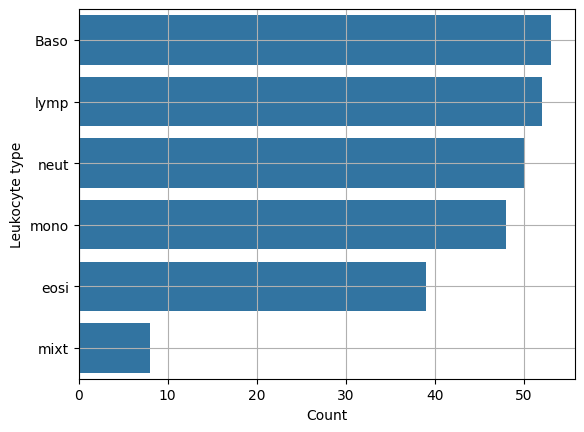

In [6]:
leu_types = images_df.leu_type.unique()
fig, ax = plt.subplots()
ax = sns.countplot(y=images_df["leu_type"], order = images_df['leu_type'].value_counts().index, color=sns.color_palette()[0])
ax.set_ylabel("Leukocyte type")
ax.set_xlabel("Count")
ax.grid()
fig.show()

# Image Preprocessing
As all the images have the same size, the usual *image resizing* procedures are skipped.
Normalization, data augmentation, noise removal, contrast and edge enhancement and data balacing techniques are involved.
These operations will be performed on the fly in order to conserve physical memory and RAM, at the expense of an extra step required of the CPU for each step. This is the best trade-off given the capacities of Google Drive. To quote Francesco Sciortino:

"*All other things being equal, we should choose the most efficient sampling procedure.*
*But, to this end, we must first define what we mean by efficient sampling. In very vague terms, sampling is efficient if it gives you good value for money. Good value in a simulation corresponds to high statistical accuracy, and ”money” is simply money: the money that buys your computer time and even your own time. For the sake of the argument, we assume the average scientific programmer is poorly paid."*

In [7]:
import torch
import torchvision.transforms as transforms

def transform_image(image, transform):
  # Apply the transformation
  transformed_image = transform(image)

  # Convert and return the transformed tensor back to an image
  return transforms.ToPILImage()(transformed_image)

def plot_side_to_side(image, transform):
  transformed_image = transform_image(image, transform)

  # Display the original and transformed images side by side
  fig, axes = plt.subplots(1, 2, figsize=(10,10))

  # Original image
  axes[0].imshow(image)
  axes[0].set_title("Original Image")
  axes[0].axis("off")

  # Transformed image
  axes[1].imshow(transformed_image)
  axes[1].set_title("Transformed Image")
  axes[1].axis("off")

  return fig

## Normalization
This step helps bring the pixel values to a similar scale and prevents any single channel from dominating the learning process.
The procedure is obtained by subtracting the mean and dividing by the standard deviation for each channel, the image pixel values are shifted and scaled, resulting in a mean of zero and a standard deviation of one for each channel. This normalization process helps bring the pixel values to a similar scale and makes the training process more stable and efficient.

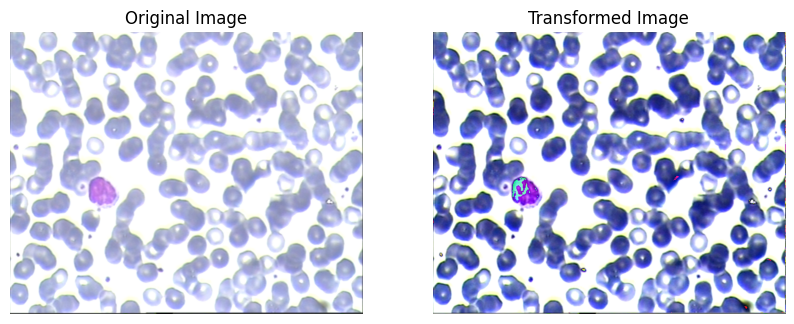

In [8]:
image = cv2.imread(main_dataset_image_path,1)

transform = transforms.Compose([
    transforms.ToPILImage(),                                    # Convert image to PIL Image
    transforms.ToTensor(),                                      # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))           # Normalize the image - (vector of means), (vector of std. dev)
])

image = cv2.imread(main_dataset_image_path)                     # open an image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                  # convert from BGR (cv2 format) to RGB

fig = plot_side_to_side(image, transform)
fig.show()

## Data Augmentation
Apply data augmentation techniques to increase the size and diversity of your dataset. Data augmentation helps improve the generalization and robustness of your model by introducing variations in the images. Common augmentation techniques include random rotations, flips, translations, and zooms. PyTorch provides the `torchvision.transforms` module that you can use to apply these transformations to your images.

<img src="https://www.labellerr.com/blog/content/images/2022/11/data.augmentation-1.webp" width=200>


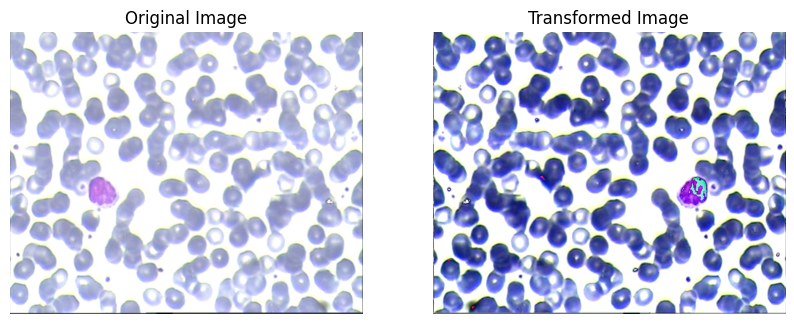

In [9]:
image = cv2.imread(main_dataset_image_path,1)

transform = transforms.Compose([
    transforms.ToPILImage(),                                          # Convert image to PIL Image
    transforms.ToTensor(),                                            # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),           # Normalize the image
    transforms.RandomHorizontalFlip(p=1),                             # Fli the image
])

image = cv2.imread(main_dataset_image_path)                     # open an image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                  # convert from BGR (cv2 format) to RGB

fig = plot_side_to_side(image, transform)
fig.show()

## Noise reduction
Apply denoising techniques to remove noise from the images. Noise can interfere with the segmentation process and degrade the performance of your model. Techniques such as median filtering, Gaussian filtering, or total variation denoising can be employed to reduce noise while preserving the important features.

For this project a Gaussian Blurm is employed as this will help in the edge detection process. The kernel size is 3x3 as the noise is not very high and the information on edges are valuable still.

<img src="https://i0.wp.com/www.adeveloperdiary.com/wp-content/uploads/2019/05/kernels-Applying-Gaussian-Smoothing-to-an-image-using-Python-from-scratch-adeveloperdiary.com_.jpg" height=200>

<img src="https://help.pixelmator.com/pixelmator-pro/3.3/assets/English/1589980508000.png" height=200>



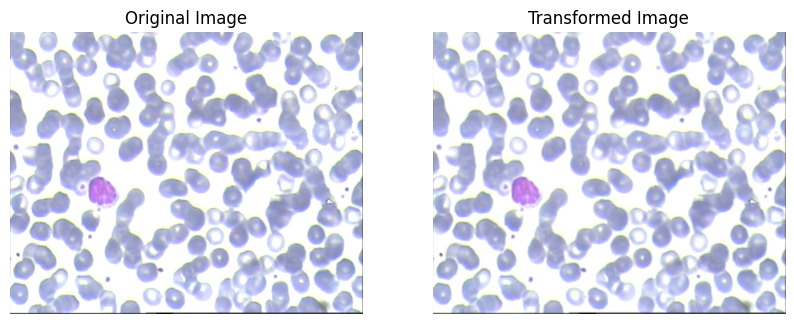

In [10]:
def remove_noise(image):
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    return blurred_image

image = cv2.imread(main_dataset_image_path,1)

transform = transforms.Compose([
    transforms.Lambda(remove_noise),
    transforms.ToPILImage(),                                          # Convert image to PIL Image
    transforms.ToTensor(),                                            # Convert image to tensor
])

image = cv2.imread(main_dataset_image_path)                     # open an image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                  # convert from BGR (cv2 format) to RGB

fig = plot_side_to_side(image, transform)
fig.show()

## Contrast Enhancement
Adjust the contrast of the images to improve the visibility of the leukocytes.
To achieve this a threshold method is introduced.

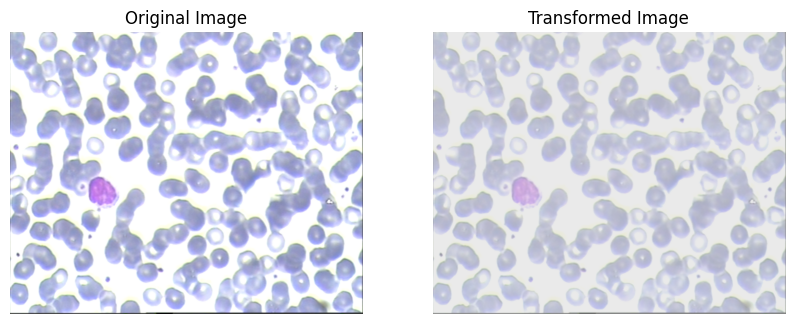

In [11]:
image = cv2.imread(main_dataset_image_path,1)

transform = transforms.Compose([
    transforms.ToPILImage(),                                              # Convert image to PIL Image
    transforms.Lambda(lambda image: transforms.functional.adjust_contrast(image, 0.5)),
    transforms.ToTensor(),                                                # Convert image to tensor
])

image = cv2.imread(main_dataset_image_path)                     # open an image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                  # convert from BGR (cv2 format) to RGB

fig = plot_side_to_side(image, transform)
fig.show()

## Edge Enhancement
Enhance the edges and boundaries of the leukocytes to make them more distinguishable. Techniques like edge detection algorithms (e.g., Canny edge detector) or morphological operations (e.g., dilation and erosion) can help highlight the edges and improve segmentation results.

For this part a GaussianBlur is employed to capture the borderline of each cell. That it is added to the original image. For this reason an extra normalization layer is employed.

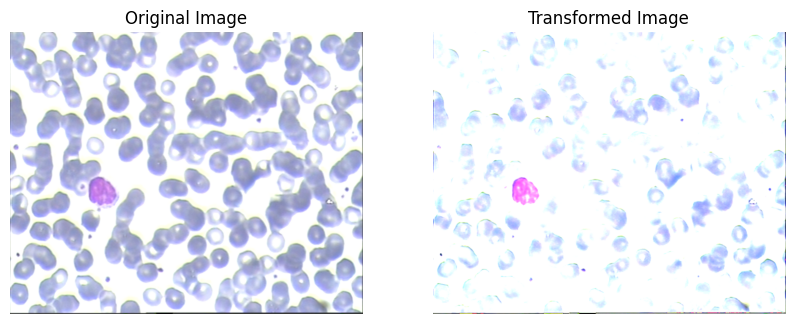

In [12]:
def enhance_edges(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the Gaussian difference filter
    blurred_image = cv2.GaussianBlur(gray_image, (0, 0), 3)
    edge_image = cv2.subtract(gray_image, blurred_image)

    # Convert the edge image back to RGB
    edge_image_rgb = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2RGB)

    # Combine the edge image with the original image
    enhanced_image = cv2.addWeighted(image, 1.5, edge_image_rgb, 0.5, 0)

    return enhanced_image

transform = transforms.Compose([
    transforms.Lambda(enhance_edges),
    transforms.ToPILImage(),                                              # Convert image to PIL Image
    transforms.ToTensor(),                                                # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))          # Normalize the image
])

image = cv2.imread(main_dataset_image_path)                     # open an image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                  # convert from BGR (cv2 format) to RGB

fig = plot_side_to_side(image, transform)
fig.show()

This looks particularly promissing for the implementation.

## Edge Enhancement

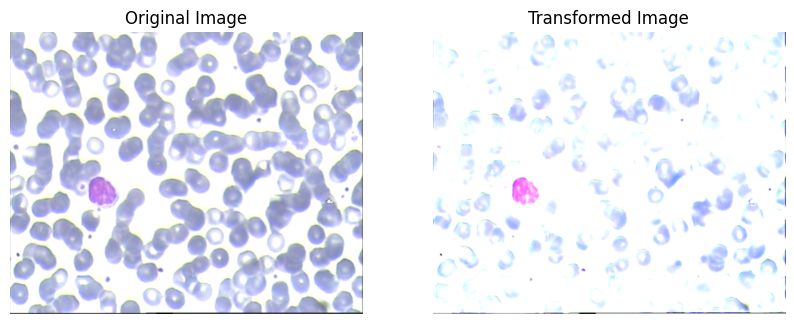

In [13]:
def enhance_edges(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the Gaussian difference filter
    blurred_image = cv2.GaussianBlur(gray_image, (0, 0), 3)
    edge_image = cv2.subtract(gray_image, blurred_image)

    # Convert the edge image back to RGB
    edge_image_rgb = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2RGB)

    # Combine the edge image with the original image
    enhanced_image = cv2.addWeighted(image, 1.5, edge_image_rgb, 0.5, 0)

    return enhanced_image

def remove_noise(image):
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    return blurred_image

transform = transforms.Compose([
    transforms.Lambda(remove_noise),
    transforms.Lambda(enhance_edges),
    transforms.ToPILImage(),                                              # Convert image to PIL Image
    transforms.ToTensor(),                                                # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                # Normalize the image
])

image = cv2.imread(main_dataset_image_path)                                # open an image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                             # convert from BGR (cv2 format) to RGB

fig = plot_side_to_side(image, transform)
fig.show()

## Preprocessing: split images
Notice that the size of the leukocyte relative to the image is rather small. To overcome this problem, the image is splitted in four and only the "splits" containing the leukocyte are selected.

In [14]:
rows = []
image_folder = './Preprocessed/'
mode = 'load' #@param ['load', 'execute']
df_filename = 'preprocessed_images_df.pickle' #@param {type:'string'}
n_splits = 1 #@param {type:"number"}
df_path = os.path.join(image_folder, df_filename)
if mode == 'load':
  preprocessed_images_df = pd.read_pickle(df_path)
else:

  if os.path.exists(image_folder) is False:
    os.mkdir(image_folder)
  !rm ./Preprocessed/*

  for i in range(images_df.shape[0]):
    image_path = images_df.iloc[i]['path_image']
    segmentation_path = images_df.iloc[i]['path_segmentation']
    leu_type = images_df.iloc[i]['leu_type']
    id_num = images_df.iloc[i]['id']

    img = cv2.imread(image_path, 1)
    seg = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

    resize_function = lambda x: cv2.resize(x, (256, 256), interpolation = cv2.INTER_AREA)
    img = resize_function(img).astype(np.float32)
    seg = resize_function(seg).astype(np.float32)

    height, width, _ = img.shape
    split_height = height // n_splits
    split_width = width // n_splits

    segmentation_parts = []
    image_parts = []

    for irow in range(n_splits):
      for icol in range(n_splits):
        segmentation_parts.append(seg[irow * split_height:(irow+1) * split_height, icol* split_width:(icol+1) * split_width])
        image_parts.append(img[irow * split_height:(irow+1) * split_height, icol* split_width:(icol+1) * split_width])


    leu_in_indices = [i for i in range(len(segmentation_parts)) if np.sum(np.argwhere(segmentation_parts[i] > 0)) > 0]

    image_name = lambda leu_type, id, index: f'{leu_type}_{id}_{index}.bmp'
    segmentation_name = lambda leu_type, id, index: f'{leu_type}_{id}_{index}_seg.bmp'

    for index in leu_in_indices:
      cv2.imwrite(os.path.join(image_folder, image_name(leu_type, id_num, index)), image_parts[index])
      cv2.imwrite(os.path.join(image_folder, segmentation_name(leu_type, id_num, index)), segmentation_parts[index])
      rows.append((id_num, leu_type, os.path.join(image_folder, image_name(leu_type, id_num, index)), os.path.join(image_folder, segmentation_name(leu_type, id_num, index))))

  preprocessed_images_df = pd.DataFrame(rows, columns = ['id', 'leu_type', 'path_image', 'path_segmentation'])
  preprocessed_images_df.to_pickle(df_path)

# Architecteure: UNet
<img src='https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png' width = 500>

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg.[1] The network is based on the fully convolutional network[2] and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 x 512 image takes less than a second on a modern GPU.

Among the other application there are:
* Pixel-wise regression using U-Net and its application on pansharpening;
* 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation;
* TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation.
* Image-to-image translation to estimate fluorescent stains
* In binding site prediction of protein structure.

[1] Ronneberger O, Fischer P, Brox T (2015). "U-Net: Convolutional Networks for Biomedical Image Segmentation". arXiv:1505.04597

[2] Shelhamer E, Long J, Darrell T (April 2017). "Fully Convolutional Networks for Semantic Segmentation". IEEE Transactions on Pattern Analysis and Machine Intelligence. 39 (4): 640–651. arXiv:1411.4038

## Loss Function: Binary cross Entropy

To Do EQ

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=64, threshold=0.05):
        super(UNet, self).__init__()

        features = init_features
        self.threshold = threshold
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = UNet._MaxPool2d()
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = UNet._MaxPool2d()
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = UNet._MaxPool2d()
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = UNet._MaxPool2d()

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.threshold_filter = nn.Threshold(self.threshold, 0)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        out = torch.sigmoid(self.conv(dec1))
        out_threshold = self.threshold_filter(out)
        return out_threshold

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + " conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + " norm1", nn.BatchNorm2d(num_features=features)),
                    (name + " relu1", nn.ReLU(inplace=True)),
                    (
                        name + " conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + " norm2", nn.BatchNorm2d(num_features=features)),
                    (name + " relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

    @staticmethod
    def _MaxPool2d():
        return nn.MaxPool2d(kernel_size=2, stride=2)

## Combined Loss Function for Deep Supervision

The combined loss function is designed to provide a flexible approach for evaluating the similarity between the reconstructed image and the target image, with the ability to emphasize either the overall image reconstruction or the non-black pixels.

The loss function consists of two components: $L_1$ loss and $L_2$ loss. The $L_1$ loss measures the average absolute difference between the reconstructed image and the target image, while the $L_2$ loss measures the average difference of the non black pixels.

The loss function introduces a parameter called $\alpha$, which controls the importance given to the reconstruction of the overall image versus the non-black pixels.
In particular when $\alpha = 0$, the loss function is minimized when the reconstructed image matches the target image as a whole. On the other hand, when $\alpha = 1$, the loss function is minimized when only the non-black pixels in both the reconstructed and target images are the same.

By adjusting the value of alpha, one can prioritize either the global image reconstruction or the fidelity of the non-black pixels in the segmentation. This allows for a flexible and customizable approach to training the model based on the specific requirements of the task at hand.



In [16]:
class CombinedLoss(nn.Module):
  def __init__(self, alpha):
    super(CombinedLoss, self).__init__()
    self.alpha = alpha

  def forward(self, segmentation, ground_truth):

    n_no_black = torch.sum(ground_truth > 0)
    indices_no_black = torch.nonzero(ground_truth, as_tuple=True)
    segmentation_no_black = segmentation[indices_no_black]
    ground_truth_no_black = ground_truth[indices_no_black]

    L_1 = torch.sum(torch.abs(segmentation_no_black - ground_truth_no_black)) / n_no_black
    L_2 = torch.sum(torch.abs(segmentation - ground_truth)) / n_no_black
    alpha = self.alpha
    return alpha * L_1 + (1-alpha) * L_2


## Custom Dataset

The `CustomDataset` class is a PyTorch dataset implementation for loading image and segmentation data from a given dataframe.

### Class Definition

The `CustomDataset` class inherits from the `Dataset` class provided by PyTorch and overrides three key methods: `__init__()`, `__len__()`, and `__getitem__()`.

- `__len__(self)`: This method returns the length of the dataset, which corresponds to the number of samples in the dataframe.

- `__getitem__(self, index)`: This method retrieves a specific sample from the dataset at the given index. It loads the corresponding image and segmentation paths from the dataframe, reads the image and segmentation using OpenCV, applies the optional transform if provided, resizes the images and segmentations to a specified size, and converts them to tensors. The pixel values of the tensors are then normalized to the range [0, 1] by dividing by 255.

In [17]:
class CustomDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index]['path_image']
    segmentation_path = self.dataframe.iloc[index]['path_segmentation']

    image = cv2.imread(image_path,1)
    segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
      image = transform_image(image, self.transform)

    resize_function = lambda x: cv2.resize(x, (64, 64), interpolation = cv2.INTER_AREA)
    image = resize_function(image).astype(np.float32)
    segmentation = resize_function(segmentation).astype(np.float32)

    tensor_image = ToTensor()(image) / 255.
    tensor_segmentation = ToTensor()(segmentation) / 255.

    return tensor_image, tensor_segmentation


## ModelCheckpointCallback

The `ModelCheckpointCallback` class is a callback implementation used during the training of a model to save checkpoints at specified intervals. It allows you to save the model's weights and associated information for future use or analysis.

### Usage

To use the `ModelCheckpointCallback`, create an instance of the class and pass the required arguments. During training, call the callback at the end of each epoch, providing the current epoch number, the model, and the loss value. The callback will handle the saving of checkpoints based on the specified interval.

```python
# Example usage
checkpoint_callback = ModelCheckpointCallback(checkpoints_dir='./checkpoints', n_epoch=5)
for epoch in range(num_epochs):
    # Training loop
    # ...

    # At the end of each epoch
    checkpoint_callback(epoch, model, loss)


In [18]:
class ModelCheckpointCallback:
    def __init__(self, checkpoints_dir, n_epoch, debug=False):
        if debug: return None
        self.checkpoints_dir = checkpoints_dir
        self.n_epoch = n_epoch
        log_name_id = datetime.now().strftime("%Y-%m-%d %H:%M")
        self.checkpoint_path = os.path.join(checkpoints_dir, "Train " + log_name_id)
        self.log_path = os.path.join(self.checkpoint_path, "Log: " + log_name_id + ".dat")

        if os.path.exists(self.checkpoints_dir) is False:
          os.mkdir(self.checkpoints_dir)

        if os.path.exists(self.checkpoint_path) is False:
          os.mkdir(self.checkpoint_path)

        with open(self.log_path, 'a') as fp:
              fp.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}: Training starts.\n")

    def __call__(self, epoch, model, loss):
        if debug:
          print("Debug mode: no savings")
          return None
        if (epoch + 1) % self.n_epoch == 0:
            checkpoint_parameters_filename = f"model_epoch_{epoch + 1}.pt"
            checkpoint_parameters_path = os.path.join(self.checkpoint_path, checkpoint_parameters_filename)
            torch.save(model.state_dict(), checkpoint_parameters_path)
            with open(self.log_path, 'a') as fp:
              fp.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}:\n\tweights saved in {checkpoint_parameters_path}")
              fp.write(f"\n\tloss: {loss[-1]}\n\n")
        return None


## Helper functions

In [19]:
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from skimage.transform import resize
from datetime import datetime

def get_train_test_dataset(dataset, DataSet = CustomDataset,
                               train_set_frac=0.8,
                               transform=None):

  train_ = dataset.sample(frac=train_set_frac)
  indices = train_.index
  test_ = dataset.drop(indices)
  train_dataset = DataSet(train_, transform=transform)
  test_dataset = DataSet(test_, transform=transform)

  return train_dataset, test_dataset

def show_progress(model, images, segmentations):

  transform = T.ToPILImage()

  reconstructed_segmentation = transform(model(images)[0,0,:,:])
  image = transform(images[0,:,:,:])
  segmentation = transform(segmentations[0,0,:,:])

  fig, axs = plt.subplots(1,3)
  axs[0].imshow(image, cmap='gray', vmin=0, vmax=255)
  axs[0].set_title("Original")
  axs[0].axis('off')
  axs[1].imshow(reconstructed_segmentation, cmap='gray', vmin=0, vmax=255)
  axs[1].set_title("Reconstructed mask")
  axs[1].axis('off')
  axs[2].imshow(segmentation, cmap='gray', vmin=0, vmax=255)
  axs[2].set_title("Original mask")
  axs[2].axis('off')
  return fig, axs


In [20]:
#@title Training of the UNet
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

debug = False #@param {type: 'boolean'}
train_set_frac = 0.75 #@param {type: 'number'}
load = True #@param {type: 'boolean'}
param_path_load = './Checkpoints/model_final.pt' #@param {type: 'string'}
train = False #@param {type: 'boolean'}
alpha = 0.95 #@param {type: 'slider', min:0, max:1.0, step:0.05}
batch_size = 32 #@param {type: 'slider', min:16, max:256, step:16}

if debug:
  train_dataset, test_dataset = get_train_test_dataset(preprocessed_images_df.iloc[:16,:], train_set_frac=train_set_frac)
else:
  train_dataset, test_dataset = get_train_test_dataset(preprocessed_images_df, train_set_frac=train_set_frac)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

in_channels = 3
out_channels = 1

model = UNet(in_channels=in_channels, out_channels=out_channels, threshold = 0.3).to(device)
model = model.to(device)

if load:
  model.load_state_dict(torch.load(param_path_load, map_location=device))  # Load the saved parameters

if train:
  # optimizer = optim.Adam(model.parameters(), lr=0.001)
  optimizer = optim.SGD(model.parameters(), lr=0.001)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Define the scheduler
  # loss_fn = nn.BCEWithLogitsLoss().to(device)
  loss_fn = CombinedLoss(alpha=alpha).to(device)

  num_epochs = 5000
  save_epochs = 20 if device == 'cpu' else 100
  checkpoint_callback = ModelCheckpointCallback(checkpoints_dir='./Checkpoints', n_epoch=save_epochs, debug=debug)
  epoch_display = display(display_id=True)
  batch_display = display(display_id=True)
  progress_display = display(display_id=True)
  loss_epoch = []

  epoch_display.update(f"{datetime.now().strftime('%Y-%m-%d %H:%M')}: Training starts.")
  epoch_display.update(f"Dataset shape: {preprocessed_images_df.shape}")

  num_batches = len(train_loader)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    for i, (images, targets) in enumerate(train_loader):

        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()
        batch_display.update(f"{datetime.now().strftime('%Y-%m-%d %H:%M')}: Batch: [{i+1}/{num_batches}]")

    scheduler.step()
    loss_epoch.append(loss.item())
    checkpoint_callback(epoch, model,loss_epoch)
    clear_output(wait=True)
    fig, axs = show_progress(model, images, targets)
    plt.show()
    epoch_display.update(f"{datetime.now().strftime('%Y-%m-%d %H:%M')}: Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")


## Image classification task

In [21]:
class ImageClassifier(nn.Module):
    def __init__(self, HW = 64, pool_size = 2, num_classes = 6):
        super(ImageClassifier, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(6 * (HW // 2) ** 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        if x.shape[2] != x.shape[3]:
          raise ValueError(f'Input images must be a squares. Detected width, height = ({x.shape[2]}, {x.shape[3]})')

        x = self.conv(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

class MaxArg(nn.Module):
  def __init__(self):
    super(MaxArg, self).__init__()

  def forward(self, x):
    max_indices = torch.argmax(x, dim=1)
    result = torch.zeros_like(x).type(torch.uint8)
    result[torch.arange(result.size(0)), max_indices] = 1
    return result

In [22]:
class CustomDatasetImageSeg(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    categories = list(dataframe.leu_type)
    self.unique_categories = list(dataframe.leu_type.unique())
    self.category_to_index = {category: index for index, category in enumerate(self.unique_categories)}

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index]['path_image']
    image = cv2.imread(image_path,1)
    if self.transform is not None:
      image = transform_image(image, self.transform)

    resize_function = lambda x: cv2.resize(x, (64, 64), interpolation = cv2.INTER_AREA)
    image = resize_function(image).astype(np.float32)

    category = self.dataframe.iloc[index]['leu_type']
    encoded_category = F.one_hot(torch.tensor(self.category_to_index[category]), num_classes=len(self.unique_categories))

    tensor_image = ToTensor()(image) / 255.

    return tensor_image, encoded_category.type(torch.FloatTensor)


In [ ]:
#@title Training of the classification
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

debug = False #@param {type: 'boolean'}
train_set_frac = 0.75 #@param {type: 'number'}
param_unet_path_load = './Checkpoints/model_final.pt' #@param {type: 'string'}
train = True #@param {type: 'boolean'}

batch_size = 32 #@param {type: 'slider', min:16, max:256, step:16}

if debug:
  train_dataset, test_dataset = get_train_test_dataset(preprocessed_images_df.iloc[:16,:], DataSet = CustomDatasetImageSeg,train_set_frac=train_set_frac)
else:
  train_dataset, test_dataset = get_train_test_dataset(preprocessed_images_df, DataSet = CustomDatasetImageSeg,train_set_frac=train_set_frac)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

in_channels = 3
out_channels = 1
out_categories = 6

model_segmentation = UNet(in_channels=in_channels, out_channels=out_channels, threshold = 0.3).to(device)
model_segmentation = model_segmentation.to(device)
model_segmentation.load_state_dict(torch.load(param_path_load, map_location=device))  # Load the saved parameters
model_segmentation = model_segmentation.eval()

model_cat = ImageClassifier(num_classes = out_categories)

if train:
  optimizer = optim.SGD(model.parameters(), lr=0.001)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Define the scheduler

  loss_fn = nn.BCEWithLogitsLoss().to(device)

  num_epochs = 5000
  save_epochs = 20 if device == 'cpu' else 100
  checkpoint_callback = ModelCheckpointCallback(checkpoints_dir='./Checkpoints/Classification', n_epoch=save_epochs, debug=debug)
  epoch_display = display(display_id=True)
  batch_display = display(display_id=True)
  progress_display = display(display_id=True)
  loss_epoch = []

  epoch_display.update(f"{datetime.now().strftime('%Y-%m-%d %H:%M')}: Training starts.")
  epoch_display.update(f"Dataset shape: {preprocessed_images_df.shape}")

  num_batches = len(train_loader)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    for i, (images, leu_categories) in enumerate(train_loader):

        images = images.to(device)
        leu_categories = leu_categories.to(device)

        # Forward pass
        output_unet = model_segmentation(images)
        outputs = model_cat(output_unet)

        loss = loss_fn(outputs, leu_categories)

        # Backward pass
        loss.backward()
        optimizer.step()
        batch_display.update(f"{datetime.now().strftime('%Y-%m-%d %H:%M')}: Batch: [{i+1}/{num_batches}]")

    scheduler.step()
    loss_epoch.append(loss.item())
    epoch_display.update(f"{datetime.now().strftime('%Y-%m-%d %H:%M')}: Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")


'2023-07-03 15:26: Epoch [5/5000], loss: 0.7107'

'2023-07-03 15:27: Batch: [5/6]'